In [5]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
#import matplotlib.pyplot as plt

path = Path('/home/thor/notebooks/sensorx-contaminant-detection/TestData/')
path.ls()

In [32]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.51
fastprogress  : 0.1.20
torch         : 1.0.1
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7301 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1039-azure-x86_64-with-debian-stretch-sid
distro        : #43-Ubuntu SMP Fri Feb 15 17:43:49 UTC 2019
conda env     : Unknown
python        : /data/anaconda/envs/py35/bin/python
sys.path      : /data/anaconda/envs/py35/lib/python36.zip
/data/anaconda/envs/py35/lib/python3.6
/data/anaconda/envs/py35/lib/python3.6/lib-dynload

/data/anaconda/envs/py35/lib/python3.6/site-packages
/data/anaconda/envs/py35/lib/python3.6/site-packages/IPython/extensions
/data/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to 

In [33]:
path_lbl = path/'masks'
path_img = path/'images'

In [34]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/images/MAGNA_52_-1CL_0.213672kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/images/MAGNA_76_74.629CL_3.52099kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/images/MAGNA_31_86.69CL_3.25324kg.tif')]

In [35]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/masks/MAGNA_52_-1CL_0.213672kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/masks/MAGNA_76_74.629CL_3.52099kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData/masks/MAGNA_31_86.69CL_3.25324kg.tif')]

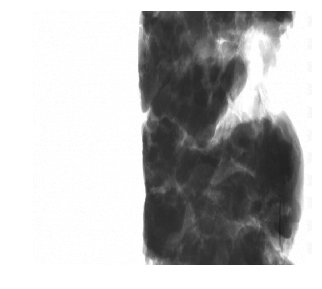

In [36]:
## Data

img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [37]:
img_f.parent.parent

PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/TestData')

/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


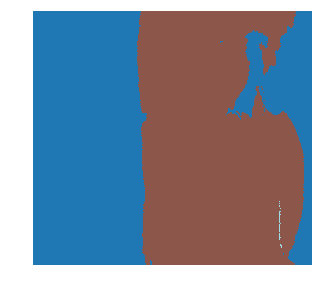

In [38]:
# TODO Continue from here...
def get_y_fn(x):
    print(str(x.parent))
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
#plt.show()

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [39]:
## Datasets
bs,size = 4,src_size//2

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/images
/home/thor/notebooks/sensorx-contaminant-detection/TestData/im

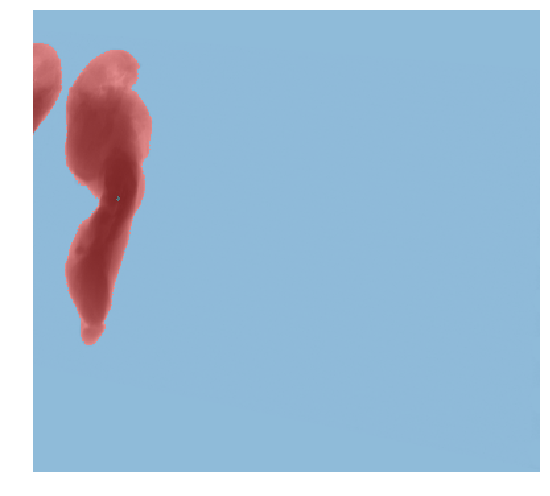

In [40]:
data.show_batch(1, figsize=(10,7))

In [42]:
name2id = {v:k for k,v in enumerate(codes)}

def error_measure(input, target):
    target = target.squeeze(1)
    mask_isVoid = target != name2id['Belt']
    mask_isBone = target == name2id['Bone']
    mask_ismetal = target == name2id['Metal']
    
    error = (input.argmax(dim=1)[mask_isVoid]!=target[mask_isVoid]).float().mean()
    boneError = input.argmax(dim=1)[mask_isBone]!=target[mask_isBone]
    metalError = input.argmax(dim=1)[mask_ismetal]!=target[mask_ismetal]
    if len(boneError) != 0:
        error += 10*boneError.float().mean()
    if len(metalError) != 0:
        error += 100*metalError.float().mean()
    
    return error

In [6]:
weights = torch.FloatTensor([0., 1., 10., 100.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
    y_hat = y_hat.argmax(dim=1)
    y = y.squeeze(1)
    
    costs = weights[y] * torch.log(y_hat.float() + 1e-16) # epsilon=1e-45
    cost = costs.sum().double()
    return cost

weight = torch.FloatTensor([1., 1., 2., 5.]).cuda()
def customLossFunction(input, target): # Works
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
# Works
class CustomLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 2., 5.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [55]:
wd=1e-2

In [56]:
# The image is reduced by half (data.batch_stats), and has 3 chanels by default (the other two are set to 1)
learn = unet_learner(data, models.resnet34, metrics=error_measure, wd=wd, loss_func=CustomLoss()) #customLossFunction

# x, y = data.one_batch(DatasetType.Train, True, True)
# data.one_batch

In [57]:
# TODO: Set the new loss_func here
learn.loss_func, data.loss_func

(<function __main__.customLossFunction(input, target)>,
 FlattenedLoss of CrossEntropyLoss())

In [58]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [59]:
lr=1e-4

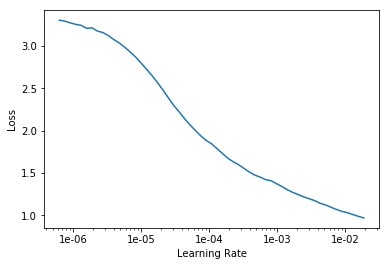

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,error_measure,time
0,2.042080,0.907799,106.739166,00:17
1,1.107674,0.184471,110.003403,00:17
2,0.741273,0.192394,110.003456,00:17
3,0.535142,0.157077,110.003296,00:17
4,0.415790,0.127075,110.002960,00:17
5,0.338390,0.143007,110.002998,00:17
6,0.278479,0.102100,110.002808,00:17
7,0.233457,0.066703,110.001816,00:17
8,0.199726,0.079280,110.001999,00:17
9,0.175568,0.084181,109.897858,00:17


In [62]:
learn.save('stage-1-big')

In [63]:
learn.load('stage-1-big');

In [64]:
learn.unfreeze()

In [65]:
lrs = slice(1e-6,lr/10)

In [66]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,error_measure,time
0,0.094986,0.072760,110.004532,00:19
1,0.090461,0.073177,93.018066,00:19
2,0.088011,0.075094,92.805893,00:18
3,0.090603,0.076188,84.526222,00:18
4,0.090247,0.083368,75.389503,00:18
5,0.086410,0.068158,59.901588,00:18
6,0.083937,0.065554,85.007538,00:18
7,0.080146,0.071073,84.150635,00:19
8,0.079239,0.074910,84.313103,00:18
9,0.076959,0.074504,84.582039,00:18


In [67]:
learn.save('stage-2-big')

In [68]:
learn.load('stage-2-big');

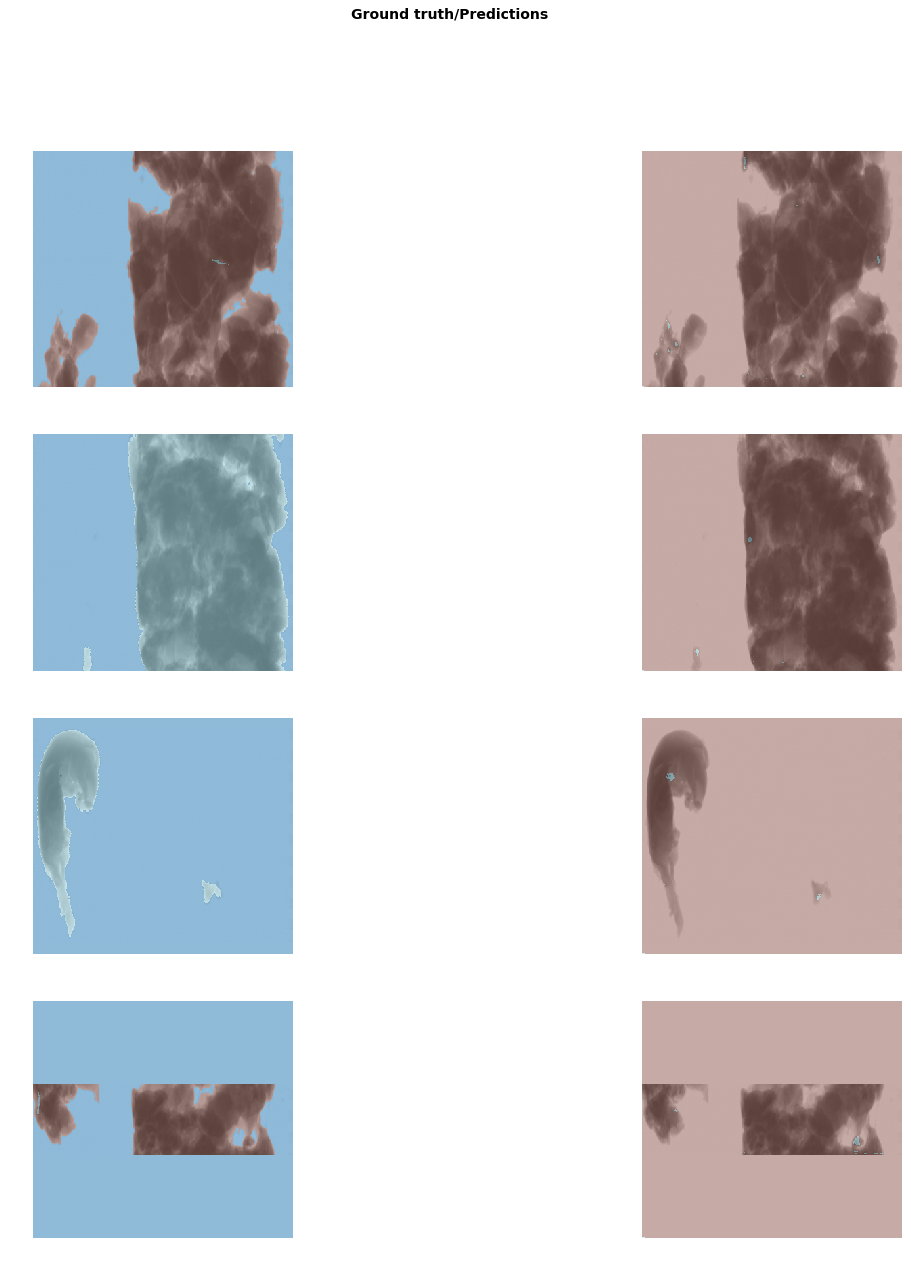

In [74]:
learn.show_results(rows=8, figsize=(20,20)) # This shows incorrect predictions?

In [70]:
preds,y = learn.get_preds()

In [71]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth/Predictions
########################
There is Bone. Found Bone.


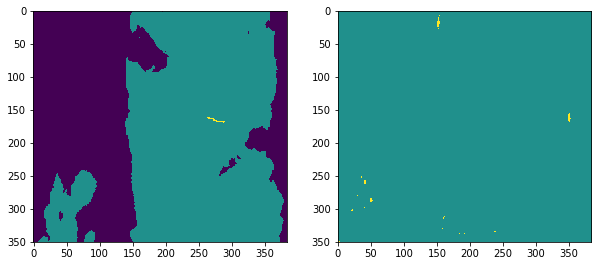

There is Metal. Found Bone.


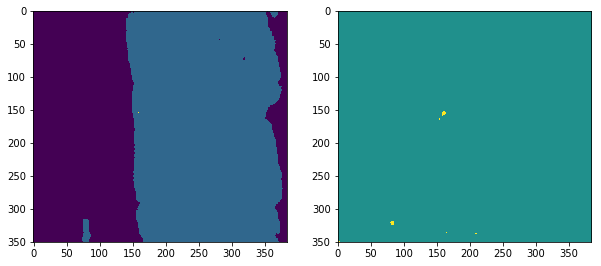

There is Metal. Found Bone.


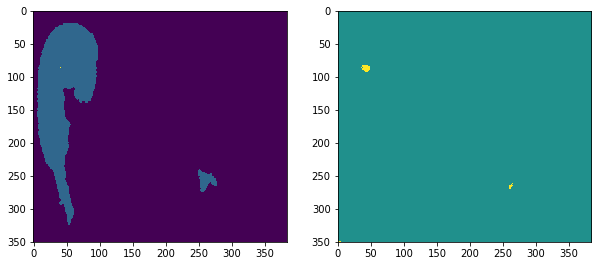

There is Bone. Found Bone.


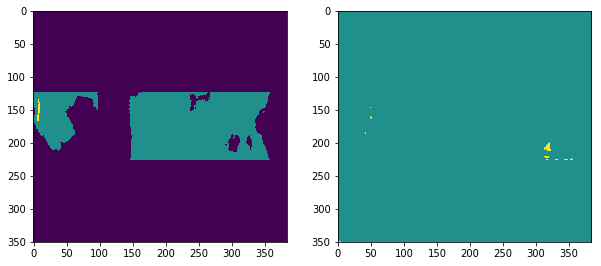

There is Metal. Found Bone and Metal.


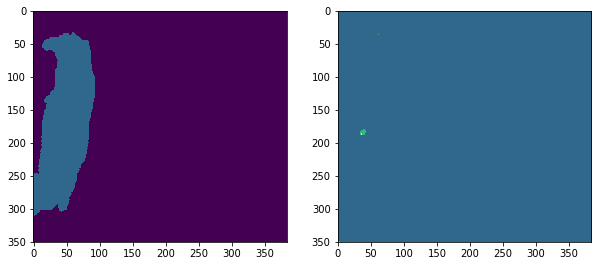

There is Bone. Found Bone.


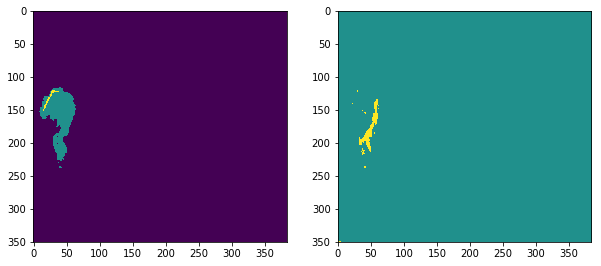

There is Metal. Found Bone and Metal.


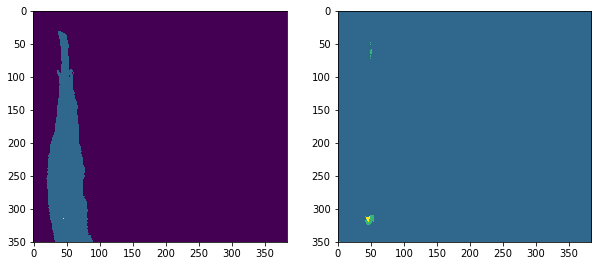

There is Metal. Found Bone and Metal.


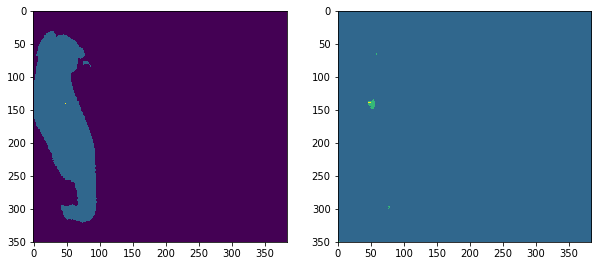

In [72]:
y = torch.squeeze(y)
print("########################")
print("Ground truth/Predictions")
print("########################")
for i in range(8):
    prediction = preds.argmax(dim=1)[i]
    print("There is {}. Found {}.".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    plt.show()
    

In [78]:
# TODO: Test this stuff
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(10,10))
interp.plot_confusion_matrix()

TypeError: customLossFunction() got an unexpected keyword argument 'reduction'

In [77]:
doc(ClassificationInterpretation)